In [ ]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from classification.datasets import Dataset
from xNNoost import XNNClassifier
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

2025-04-27 12:07:21.456573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [5]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [6]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [7]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])
# print(myds["fire", 0])

20

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [8]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
# print(f"Feature vector length: {featveclen}")
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
data_aug_factor = 1
naudio_sum = sum(naudio.values())
class_ids_aug = np.concatenate(
    [np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames]
)

X = np.zeros((data_aug_factor * naudio_sum, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]
            X[s * nclass * naudio[classname] + class_idx * naudio[classname] + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)
# Assuming classnames is already defined

# Print the names of the classes
print("Class names:", classnames)


X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()
classnames = np.unique(y)

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for classname, count in zip(unique_classes, class_counts):
    print(f"Class '{classname}': {count} samples")


Class names: ['chainsaw', 'fire', 'fireworks', 'gun']
Shape of the feature matrix : (274, 400)
Number of labels : 274
Class 'chainsaw': 80 samples
Class 'fire': 79 samples
Class 'fireworks': 75 samples
Class 'gun': 40 samples


You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


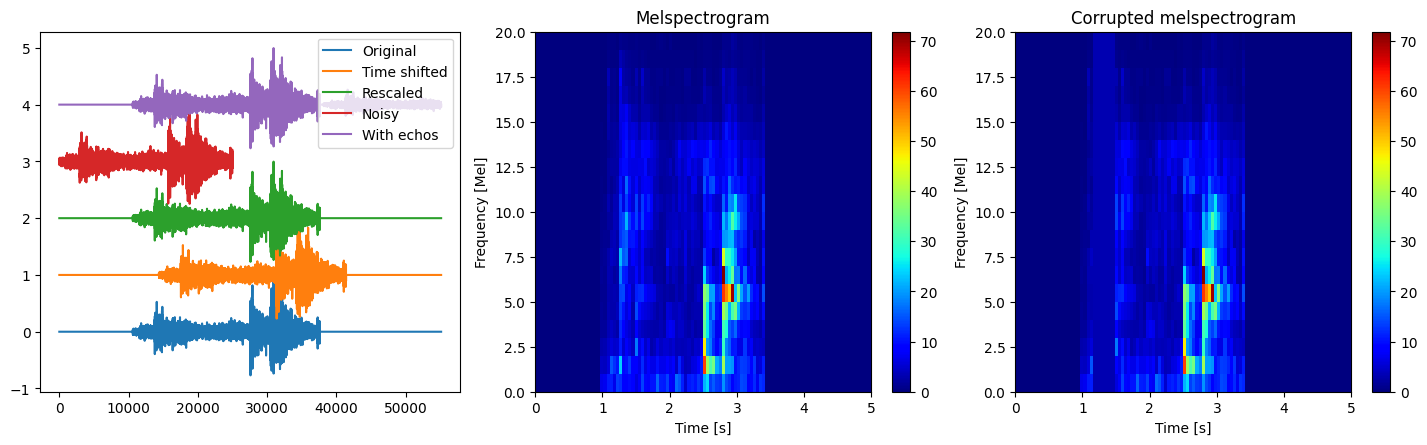

In [9]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["fire", 2]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)
audio_tmp = AudioUtil.open(sound)
AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.5)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio_tmp, sigma=1e-4)  # Create a copy before adding noise
audio6 = AudioUtil.echo(audio2)
# audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
# ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [ ]:
from tqdm import tqdm

### TO RUN
# Initialize the feature matrix and labels for multiple shift_pct values
shift_pct_values = np.arange(0, 0.96, 0.96/5).tolist()  # List of shift_pct values
X_aug_list = []
y_aug_list = []

naudio_sum = sum(naudio.values())
for shift_pct in tqdm(shift_pct_values, desc="Processing shift_pct values"):
    # Create a Feature_vector_DS for the current shift_pct
    myds_shifted = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=shift_pct)
    myds_shifted.mod_data_aug(["noise", "echo","background_noise"])
    
    # Initialize feature matrix and labels for the current shift_pct
    X_aug_shifted = np.zeros((myds_shifted.data_aug_factor * naudio_sum, featveclen))
    y_aug_shifted = np.empty((myds_shifted.data_aug_factor * naudio_sum), dtype=object)
    
    # Generate feature vectors and labels
    for s in range(myds_shifted.data_aug_factor):
        offset = 0
        for class_idx, classname in enumerate(classnames):
            num_samples = naudio[classname]  # Number of samples for the current class
            for idx in range(num_samples):
                featvec = myds_shifted[classname, idx]
                X_aug_shifted[s * naudio_sum + offset + idx, :] = featvec
                y_aug_shifted[s * naudio_sum + offset + idx] = classname
            offset += num_samples  # Update the offset for the next class
    
    # Append the current shift_pct data to the lists
    print(f"Shape of the feature matrix for shift_pct={shift_pct} : {X_aug_shifted.shape}")
    X_aug_list.append(X_aug_shifted)
    y_aug_list.append(y_aug_shifted)

# Concatenate all feature matrices and labels
X_aug = np.vstack(X_aug_list)
y_aug = np.concatenate(y_aug_list)

# Save the feature matrices
np.save(fm_dir + "feature_matrix_2D_NN.npy", X_aug)
np.save(fm_dir + "labels_2D_test_NN.npy", y_aug)

# Load the feature matrices (if necessary)
X_aug = np.load(fm_dir + "feature_matrix_2D_NN.npy")
y_aug = np.load(fm_dir + "labels_2D_test_NN.npy", allow_pickle=True)

print(f"Shape of the feature matrix : {X_aug.shape}")
print(f"Number of labels : {len(y_aug)}")

Shape of the feature matrix : (6850, 400)
Number of labels : 6850


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import keras
import pandas as pd

X_aug -= np.mean(X_aug, axis=0)
X_aug /= np.linalg.norm(X_aug, axis=0)
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(X_aug, y_aug, 
                                                                          test_size=0.3, 
                                                                          random_state=40,stratify=y_aug)
X_train_normalized = X_train_normalized.reshape(-1, 20, 20, 1)

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
# print(y_train_encoded)
# print(f"Shape of X_train_normalized: {X_train_normalized.shape}")
# print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
# print(f"Number of classes: {len(np.unique(y_train_encoded))}")
def create_cnn_model(dropout_conv=0.25, dropout_dense=0.5, learning_rate=0.001):
    model = Sequential()
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', 
                     input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# model = create_cnn_model()
# # Fit the model on 100 epochs
# model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=32, verbose=1)



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
balanced accuracy score: 0.9817


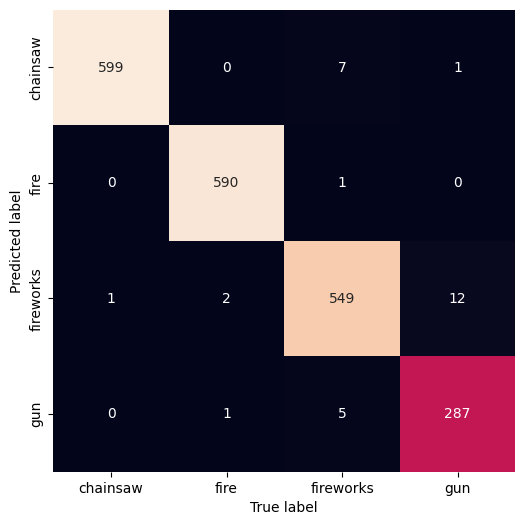

In [24]:
# test_accuracy = 0
# while test_accuracy < 0.96:
#     print("Test accuracy below 0.96, recreating and retraining the model...")
#     model = create_cnn_model()
#     model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=32, verbose=1)
#     X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))
#     test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=1)
#     print(f"Test accuracy of the current iteration: {test_accuracy:.4f}")
# print(f"Test accuracy: {test_accuracy:.4f}")
# print("Saving the best CNN model...")
# model.save("CNN_LAST.keras")
from sklearn.metrics import balanced_accuracy_score
model = keras.models.load_model("data/models/CNN_LAST.keras")
X_test_reshaped = X_test_normalized.reshape((-1, 20, 20, 1))


y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
print("balanced accuracy score:", balanced_accuracy_score(y_test_encoded, y_pred_classes).round(4))

show_confusion_matrix(y_pred_classes, y_test_encoded, classnames)

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
import pandas as pd

# Define the CNN model for Grid Search
def create_cnn_model(optimizer='adam', learning_rate=0.001, dropout_conv=0.25, dropout_dense=0.5):
    model = Sequential()
    
    # Convolution Block 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(20, 20, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Convolution Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_conv))
    
    # Dense Block
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_dense))
    model.add(Dense(4, activation='softmax'))
    
    # Optimizer choice
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# # Wrap the Keras model for GridSearchCV
# model = KerasClassifier(
#     model=create_cnn_model,
#     epochs=100,
#     batch_size=32,
#     verbose=0
# )

# # Define the parameter grid for Grid Search
# param_grid = {
#     'model__optimizer': ['adam', 'sgd', 'rmsprop'],
#     'model__learning_rate': [0.001, 0.005, 0.01],
#     'model__dropout_conv': [0.25, 0.5],
#     'model__dropout_dense': [0.5, 0.75],
# }

# # Define a custom scoring function using balanced_accuracy_score
# scorer = make_scorer(balanced_accuracy_score)

# # Perform Grid Search
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)
# grid_result = grid.fit(X_train_normalized, y_train_encoded)

# # Save results to a CSV file
# results_df = pd.DataFrame(grid_result.cv_results_)
# results_df.to_csv("grid_search_results.csv", index=False)

# # Print the best parameters and score
# print(f"Best Parameters: {grid_result.best_params_}")
# print(f"Best Balanced Accuracy Score: {grid_result.best_score_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


2025-04-27 12:07:30.107458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:07:30.107746: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:07:30.110827: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:07:30.110977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:07:30.120572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 12:07:30.121842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been

Best Parameters: {'model__dropout_conv': 0.25, 'model__dropout_dense': 0.5, 'model__learning_rate': 0.01, 'model__optimizer': 'sgd'}
Best Balanced Accuracy Score: 0.9511842983263968


Encoded labels: [0 0 3 ... 0 2 0]
Encoded labels: [2 3 1 ... 0 2 2]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[16:47:00] WARNING  5 out of the last 69 calls to <function                             ]8;id=754860;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=329035;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#157\157]8;;\
                    TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_d                            
                    istributed at 0x7b11f63f93a0> triggered tf.function retracing.                                 
                    Tracing is expensive and the excessive number of tracings could be                             
                    due to (1) creating @tf.function repeatedly in a loop, (2) passing                             
                    tensors with different shapes, (3) passing Python objects instead                              
                    of tensors. For (1), please define your @tf.function outside of the                            
                    loop. For (2), @tf.function has reduce_retracing=True option that                              
                    can avoid unnecessary retracing. For (3), please refer to                                      
                    https://www.tensorflow.org/guide/function#controlling_retracing and                            
                    https://www.tensorflow.org/api_docs/python/tf/function for  more                               
                    details.                                                                                       

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step

           WARNING  6 out of the last 71 calls to <function                             ]8;id=305025;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=632362;file:///home/ulysse/Documents/LELEC21023-grH/.venv/lib/python3.9/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py#157\157]8;;\
                    TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_d                            
                    istributed at 0x7b11f63f93a0> triggered tf.function retracing.                                 
                    Tracing is expensive and the excessive number of tracings could be                             
                    due to (1) creating @tf.function repeatedly in a loop, (2) passing                             
                    tensors with different shapes, (3) passing Python objects instead                              
                    of tensors. For (1), please define your @tf.function outside of the                            
                    loop. For (2), @tf.function has reduce_retracing=True option that                              
                    can avoid unnecessary retracing. For (3), please refer to                                      
                    https://www.tensorflow.org/guide/function#controlling_retracing and                            
                    https://www.tensorflow.org/api_docs/python/tf/function for  more                               
                    details.                                                                                       

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
65/65

/tmp/ipykernel_4884/4004981957.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'Chosen augmentations'])


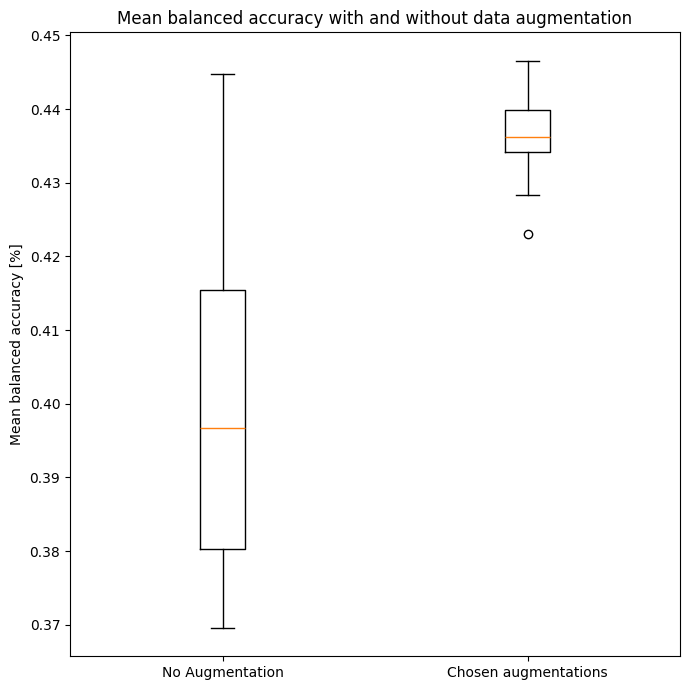

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import LabelEncoder



# Split the data

# Encode the string labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
print(f"Encoded labels: {y_train_encoded}")
print(f"Encoded labels: {y_test_encoded}")

if True:
    def evaluate_model(X_train, y_train, X_test, y_test):
        # Reshape the data to match the input shape of the CNN model
        
        # Load the pre-trained CNN model
        model = keras.models.load_model("data/models/CNN_LAST.keras")
        
        # Evaluate the model
        predictions = model.predict(X_test_reshaped)
        predictions_classes = np.argmax(predictions, axis=1)
        return balanced_accuracy_score(y_test, predictions_classes)

    # Number of evaluations to perform
    n_evaluations = 20
    X_no_aug,x_test_no_aug, y_no_aug,y_no_aug_test = train_test_split(X, y, test_size=0.3, stratify=y)
    # Evaluate without data augmentation
    accuracies_no_aug = []
    for _ in range(n_evaluations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_test_encoded = label_encoder.transform(y_test)
        accuracies_no_aug.append(evaluate_model(X_train, y_train_encoded, X_test, y_test_encoded))

    # Evaluate with all data augmentation
    X_aug_all = np.load(fm_dir + "feature_matrix_2D_NN.npy")
    y_aug_all = np.load(fm_dir + "labels_2D_test_NN.npy", allow_pickle=True)
    accuracies_all_aug = []
    for _ in range(n_evaluations):
        X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_aug_all, y_aug_all, test_size=0.3, stratify=y_aug_all)
        y_train_all_encoded = label_encoder.fit_transform(y_train_all)
        y_test_all_encoded = label_encoder.transform(y_test_all)
        accuracies_all_aug.append(evaluate_model(X_train_all, y_train_all_encoded, X_test_all, y_test_all_encoded))

    
    with PdfPages('data_augmentation_results_NN.pdf') as pdf:
        plt.figure(figsize=(7, 7))

        # Plot accuracy with and without data augmentation
        plt.boxplot([accuracies_no_aug, accuracies_all_aug], labels=['No Augmentation', 'Chosen augmentations'])
        plt.ylabel('Mean balanced accuracy [%]')
        plt.title('Mean balanced accuracy with and without data augmentation')

        plt.tight_layout()
        pdf.savefig()  # Save the current figure into a pdf page
        plt.show()